## Get Data

In [1]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_path="/content/drive/MyDrive/Project/Dataset/Updated Dataset/"

In [3]:
import json
import os
# import pandas as pd
import numpy as np
# df=pd.DataFrame()
count=0
dataset=[]
labels=[]
for folder in os.listdir(data_path)[:8]:
  for filename in os.listdir(data_path+folder)[::]:
    with open(data_path+folder+"/"+filename) as f:
      data = json.load(f)
      if(int(data['label'])>0):
        # df=df.append(pd.json_normalize(data))
        li=[]
        for i in list(data['data'].keys()):
          npdata=np.array(data['data'][i])
          li.append(np.pad(npdata,(0,10000-len(npdata)),'constant'))  #some windows smaller than 10000
        ar=np.array(li)
        dataset.append(ar)
        labels.append(int(data['label']))
      count+=1
      if(count%1000==0):
        print(count)
dataset1=np.array(dataset)

1000
2000
3000
4000
5000
6000
7000
8000


In [4]:
np.random.shuffle(dataset1)

In [5]:
#Required Imports
%matplotlib inline
# !pip install einops
# !pip install seaborn
# !pip install prettytable
# !pip install sklearn
# !pip install levenshtein
# !pip install tensorflow
import gc
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import itertools
import random
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
# from Levenshtein import distance as levenshtein_distance

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D


In [6]:
x_train=dataset1[:int(len(dataset1)*.6)]
x_val=dataset1[int(len(dataset1)*.6):int(len(dataset1)*.8)]
x_test=dataset1[int(len(dataset1)*.8):]
#shape of data
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
y_train=labels[:int(len(labels)*.6)]
y_val=labels[int(len(labels)*.6):int(len(labels)*.8)]
y_test=labels[int(len(labels)*.8):]
#shape of labels
print(len(y_train))
print(len(y_val))
print(len(y_test))
print("")
# One hot encoding of outputs


(969, 23, 10000)
(323, 23, 10000)
(324, 23, 10000)
969
323
324



In [7]:
from numpy.core.numeric import False_
is1=[]
for i in y_train:
  if i==1:
    is1.append(False)
  else:
    is1.append(True)
  
is1[::5]==True
x_train=np.asarray(x_train)[is1]
y_train=np.asarray(y_train)[is1]


is1=[]
for i in y_val:
  if i==1:
    is1.append(False)
  else:
    is1.append(True)
  
is1[::5]==True
x_val=np.asarray(x_val)[is1]
y_val=np.asarray(y_val)[is1]

is1=[]
for i in y_test:
  if i==1:
    is1.append(False)
  else:
    is1.append(True)
  
is1[::5]==True
x_test=np.asarray(x_test)[is1]
y_test=np.asarray(y_test)[is1]
del is1

In [8]:
y_train_orig=y_train
y_val_orig=y_val
y_test_orig=y_test

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
print(y_train.shape)

(607, 10)


In [9]:
#Utility functions: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

#ResNet


In [10]:
#Add your code to define a residual block below, as shown in the diagram above
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """
  
  skipdata = data
  bnorm1 = BatchNormalization()(data)
  activation1 = Activation('relu')(bnorm1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(activation1)
  bnorm2 = BatchNormalization()(conv1)
  activation2 = Activation('relu')(bnorm2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(activation2)
  x = Add()([conv2, skipdata])

  return x

In [11]:
#input
x_input = Input(shape=(23,10000))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

#Max Pooling
x = MaxPooling1D(3)(res2)
x = Dropout(0.3)(x)

#softmax classifier
x = Flatten()(x)
x_output = Dense(10, activation='softmax', kernel_regularizer=l2(0.0001))(x)

#Compile your model
model2 = Model(inputs=x_input, outputs=x_output)
# model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 23, 10000)]  0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 23, 128)      1280128     ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 23, 128)     512         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 23, 128)      0           ['batch_normalization[0][0]']

Epoch 1/50
19/19 [==============================] - 5s 166ms/step - loss: 80.0354 - accuracy: 0.1351 - val_loss: 112.7291 - val_accuracy: 0.1488
Epoch 2/50
19/19 [==============================] - 2s 126ms/step - loss: 81.5618 - accuracy: 0.2488 - val_loss: 99.6529 - val_accuracy: 0.1369
Epoch 3/50
19/19 [==============================] - 2s 126ms/step - loss: 67.4522 - accuracy: 0.2949 - val_loss: 82.4899 - val_accuracy: 0.1429
Epoch 4/50
19/19 [==============================] - 2s 126ms/step - loss: 47.3411 - accuracy: 0.3493 - val_loss: 83.6552 - val_accuracy: 0.1607
Epoch 5/50
19/19 [==============================] - 2s 129ms/step - loss: 54.1027 - accuracy: 0.3493 - val_loss: 94.0403 - val_accuracy: 0.1369
Epoch 6/50
19/19 [==============================] - 2s 130ms/step - loss: 48.7582 - accuracy: 0.3773 - val_loss: 107.9749 - val_accuracy: 0.1369
Epoch 7/50
19/19 [==============================] - 2s 127ms/step - loss: 37.6530 - accuracy: 0.3839 - val_loss: 75.3816 - val_accurac

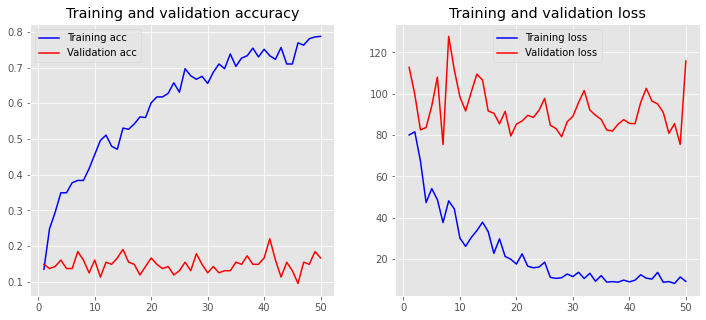

In [12]:
from tensorflow.keras.optimizers import Adam
model2.compile(optimizer=Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])
history=model2.fit( #train model and save training steps in history variable
    x=x_train,
    y=y_train,  
    batch_size=32,  
    epochs=50,  
    validation_data=(x_val, y_val)
)
plot_history(history)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Accuracy: 20.833333333333336%


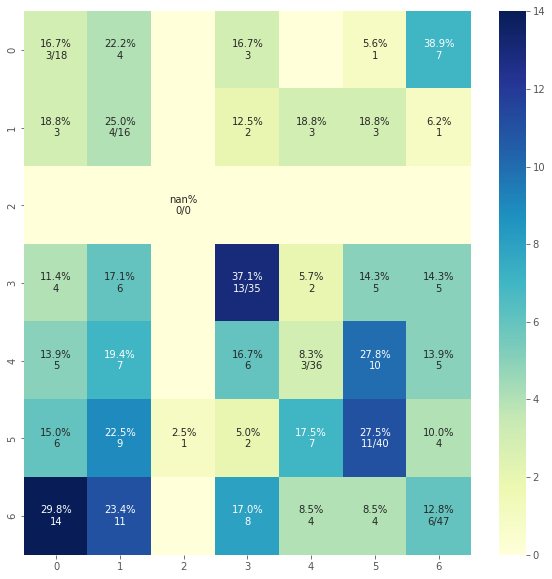

In [13]:
from sklearn.metrics import confusion_matrix
def cm_testdata(model,data_test,label_test,num_labels,letter_labels):
    # have model generate predictions on test data
    y_pred=model2.predict(data_test)
    
    # find classes with the largest predicted probabilities
    y_pred_max = np.argmax(y_pred,axis=1)
    label_max=np.argmax(label_test, axis=1)
    # plot confusion matrix
    cm = confusion_matrix(y_true=label_max, y_pred=y_pred_max)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax) 

    #accuracy

    correct = (y_pred_max == (label_max))
    accuracy = correct.sum() / correct.size *100
    print("Accuracy: "+str(accuracy)+"%")

num_labels=np.unique(y_test)
letter_labels = range(1,11)
cm_testdata(model2,x_test,y_test,num_labels,letter_labels)

#LSTM

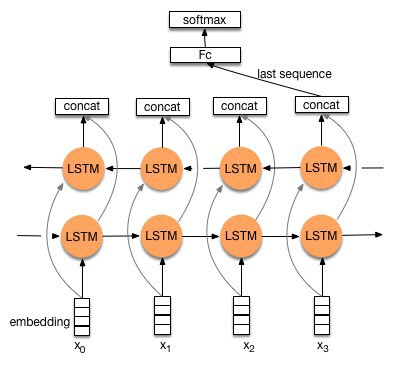

In [14]:
# Hint: use an embedding layer to project your sequence data to a higher dimension,
# and use the diagram above for some ideas on layers to include in your model.
# Remember to compile your model after designing it.
# from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
# x_input = Input(shape=(23,))
# embed = Embedding(24,40)(x_input)
# lstm = LSTM(50, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))(embed)
# x = Dropout(0.2)(lstm)

# # softmax classifier
# x_output = Dense(10, activation='softmax')(x)

# model1 = Model(inputs=x_input, outputs=x_output)
# model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model1.summary()



In [15]:
x_train_lstm = x_train.reshape(x_train.shape[0],10000,23)
x_val_lstm = x_val.reshape(x_val.shape[0],10000,23)
x_test_lstm = x_test.reshape(x_test.shape[0],10000,23)

In [16]:
try:
  del dataset1
  del x_train
  del x_val
  del x_test
except:
  pass

In [ ]:
from keras import Sequential
model3 = Sequential()
model3.add(LSTM(40, input_shape=(10000, 23)))
model3.add(Dense(10))
model3.summary()
model3.compile(loss='categorical_crossentropy', optimizer='adam')
history = model3.fit(x_train_lstm, np.asarray(y_train), epochs=10, batch_size=32, validation_data=(x_val_lstm, np.asarray(y_val)), verbose=2, shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                10240     
                                                                 
 dense_1 (Dense)             (None, 10)                410       
                                                                 
Total params: 10,650
Trainable params: 10,650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
19/19 - 78s - loss: nan - val_loss: nan - 78s/epoch - 4s/step
Epoch 2/10
19/19 - 74s - loss: nan - val_loss: nan - 74s/epoch - 4s/step
Epoch 3/10
19/19 - 73s - loss: nan - val_loss: nan - 73s/epoch - 4s/step
Epoch 4/10
19/19 - 73s - loss: nan - val_loss: nan - 73s/epoch - 4s/step
Epoch 5/10
19/19 - 73s - loss: nan - val_loss: nan - 73s/epoch - 4s/step
Epoch 6/10
19/19 - 73s - loss: nan - val_loss: nan - 73s/epoch - 4s/step
Epoch 7/10

In [ ]:
#Save your model in case you need to run again to save time with training
# model1.save_weights('/gdrive/My Drive/LSTM_Model1.h5')
model3.save_weights('LSTM_Model1.h5')

In [ ]:
model3.load_weights('LSTM_Model1.h5')

In [ ]:
extractor=Model(inputs=model1.inputs, outputs=model3.layers[1].output)
extractor(x_val).shape

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
def cm_testdata(model,data_test,label_test,num_labels,letter_labels):
    # have model generate predictions on test data
    y_pred=model3.predict(data_test)
    
    # find classes with the largest predicted probabilities
    y_pred_max = np.argmax(y_pred,axis=1)
    label_max=np.argmax(label_test, axis=1)
    # plot confusion matrix
    cm = confusion_matrix(y_true=label_max, y_pred=y_pred_max)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax) 

    #accuracy

    correct = (y_pred_max == (label_max))
    accuracy = correct.sum() / correct.size *100
    print("Accuracy: "+str(accuracy)+"%")

num_labels=6
letter_labels = range(1,7)
cm_testdata(model3,x_test_lstm,y_test,num_labels,letter_labels)

In [ ]:
y_pred=model3.predict(x_test_lstm)

In [ ]:
np.argmax(y_test,axis=1)